# FlowNet

In [1]:
# loading libraries
import numpy as np
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime


import itertools
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix

import torchvision
import warnings
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler 
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import DataLoader  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


# Model

In [7]:
try:
    from spatial_correlation_sampler import spatial_correlation_sample
except ImportError as e:
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("default", category=ImportWarning)
        warnings.warn("failed to load custom correlation module"
                      "which is needed for FlowNetC", ImportWarning)


def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )


def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=False)


def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.1,inplace=True)
    )


def correlate(input1, input2):
    out_corr = spatial_correlation_sample(input1,
                                          input2,
                                          kernel_size=1,
                                          patch_size=21,
                                          stride=1,
                                          padding=0,
                                          dilation_patch=2)
    # collate dimensions 1 and 2 in order to be treated as a
    # regular 4D tensor
    b, ph, pw, h, w = out_corr.size()
    out_corr = out_corr.view(b, ph * pw, h, w)/input1.size(1)
    return F.leaky_relu_(out_corr, 0.1)


def crop_like(input, target):
    if input.size()[2:] == target.size()[2:]:
        return input
    else:
        return input[:, :, :target.size(2), :target.size(3)]

<ipython-input-7-e20d52803bc2>:7: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  warnings.warn("failed to load custom correlation module"


In [50]:
from torch.nn.init import kaiming_normal_, constant_

class FlowNetS(nn.Module):
    expansion = 1

    def __init__(self,batchNorm=True):
        super(FlowNetS,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,   6,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm,1024, 1024)

        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                kaiming_normal_(m.weight, 0.1)
                if m.bias is not None:
                    constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                constant_(m.weight, 1)
                constant_(m.bias, 0)

    def forward(self, x):
        out_conv2 = self.conv2(self.conv1(x))
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = crop_like(self.upsampled_flow6_to_5(flow6), out_conv5)
        out_deconv5 = crop_like(self.deconv5(out_conv6), out_conv5)

        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = crop_like(self.upsampled_flow5_to_4(flow5), out_conv4)
        out_deconv4 = crop_like(self.deconv4(concat5), out_conv4)

        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = crop_like(self.upsampled_flow4_to_3(flow4), out_conv3)
        out_deconv3 = crop_like(self.deconv3(concat4), out_conv3)

        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = crop_like(self.upsampled_flow3_to_2(flow3), out_conv2)
        out_deconv2 = crop_like(self.deconv2(concat3), out_conv2)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)

        if False: #self.training:
            return flow2,flow3,flow4,flow5,flow6
        else:
            return flow2

    def weight_parameters(self):
        return [param for name, param in self.named_parameters() if 'weight' in name]

    def bias_parameters(self):
        return [param for name, param in self.named_parameters() if 'bias' in name]


def flownets(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)
    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=False)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model


def flownets_bn(data=None):
    """FlowNetS model architecture from the
    "Learning Optical Flow with Convolutional Networks" paper (https://arxiv.org/abs/1504.06852)
    Args:
        data : pretrained weights of the network. will create a new one if not set
    """
    model = FlowNetS(batchNorm=True)
    if data is not None:
        model.load_state_dict(data['state_dict'])
    return model

In [84]:
def flow2rgb(flow_map, max_value):
    flow_map_np = flow_map.detach().cpu().numpy()
    _, h, w = flow_map_np.shape
    flow_map_np[:,(flow_map_np[0] == 0) & (flow_map_np[1] == 0)] = float('nan')
    rgb_map = np.ones((3,h,w)).astype(np.float32)
    if max_value is not None:
        normalized_flow_map = flow_map_np / max_value
    else:
        normalized_flow_map = flow_map_np / (np.abs(flow_map_np).max())
    rgb_map[0] += normalized_flow_map[0]
    rgb_map[1] -= 0.5*(normalized_flow_map[0] + normalized_flow_map[1])
    rgb_map[2] += normalized_flow_map[1]
    return rgb_map.clip(0,1)

In [46]:
model = FlowNetS()

In [149]:
test_image = torch.ones(1,6,112,112)

In [235]:
image1 = torch.zeros(1,3,100,100)
image1[:,:,40:60,30:50] = 1
image2 = torch.zeros(1,3,100,100)
image2[:,:,40:60,50:70] = 1
image = torch.cat((image1, iamge2), 1)
print(image.size())

torch.Size([1, 6, 100, 100])


In [236]:
out = model(image)

In [237]:
rgb = flow2rgb(flow_map = out.squeeze(0), max_value = torch.max(out).item())

In [238]:
image1_ = image1.squeeze(0).permute(1,2,0)
image2_ = image2.squeeze(0).permute(1,2,0)

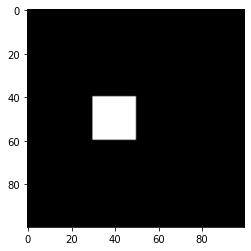

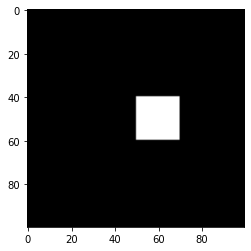

In [239]:
plt.figure()
plt.imshow(image1_)
plt.figure()
plt.imshow(image2_)

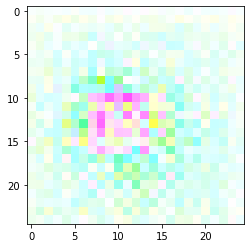

In [240]:
plt.imshow(rgb.transpose(1,2,0))